In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{device}')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 数据集的均值和标准差
])

train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

class_names = [str(i) for i in range(10)]


In [5]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x


BaseCNN(
  (conv_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


# Task a

In [11]:
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_acc_history = []
    test_acc_history = []
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        test_acc_history.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], training acc: {train_accuracy:.4f}, test acc: {test_accuracy:.4f}')
    
    return train_acc_history, test_acc_history

epochs = 5
basic_train_acc, basic_test_acc = train_model(model, train_loader, test_loader, criterion, optimizer, epochs)


Epoch [1/5], training acc: 0.9540, test acc: 0.9845
Epoch [2/5], training acc: 0.9867, test acc: 0.9893
Epoch [3/5], training acc: 0.9911, test acc: 0.9889
Epoch [4/5], training acc: 0.9923, test acc: 0.9924
Epoch [5/5], training acc: 0.9936, test acc: 0.9937


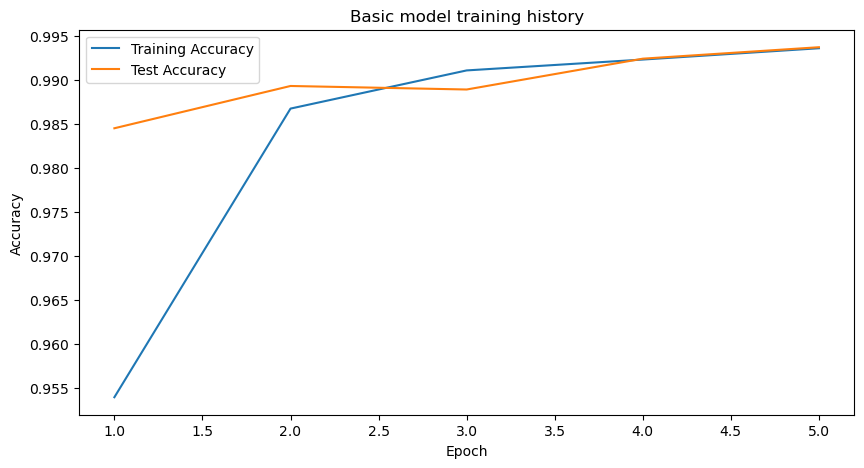

In [12]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), basic_train_acc, label='Training Accuracy')
plt.plot(range(1, epochs+1), basic_test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Basic model training history')
plt.legend()
plt.show()


# Task b

Epoch [1/5], Train Accuracy: 0.9585, Test Accuracy: 0.9884
Epoch [2/5], Train Accuracy: 0.9869, Test Accuracy: 0.9888
Epoch [3/5], Train Accuracy: 0.9900, Test Accuracy: 0.9903
Epoch [4/5], Train Accuracy: 0.9922, Test Accuracy: 0.9925
Epoch [5/5], Train Accuracy: 0.9926, Test Accuracy: 0.9928


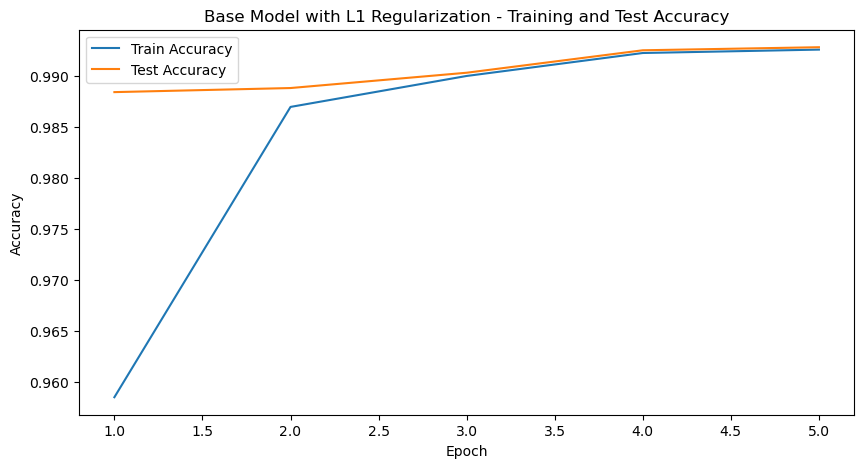

In [17]:
model_l1 = BaseCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_l1.parameters(), lr=0.001)

# Define L1 regularization parameter
l1_lambda = 1e-5

# Training function with L1 regularization
def train_model_l1(model, train_loader, test_loader, criterion, optimizer, l1_lambda, epochs=10):
    train_acc_history = []
    test_acc_history = []
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        test_acc_history.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return train_acc_history, test_acc_history

# Train the model with L1 regularization
epochs = 5
train_acc_l1, test_acc_l1 = train_model_l1(model_l1, train_loader, test_loader, criterion, optimizer, l1_lambda, epochs)

# Plot training and test accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_acc_l1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_l1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Base Model with L1 Regularization - Training and Test Accuracy')
plt.legend()
plt.show()


# Task c

Epoch [1/5], Train Accuracy: 0.9525, Test Accuracy: 0.9894
Epoch [2/5], Train Accuracy: 0.9877, Test Accuracy: 0.9858
Epoch [3/5], Train Accuracy: 0.9900, Test Accuracy: 0.9913
Epoch [4/5], Train Accuracy: 0.9918, Test Accuracy: 0.9909
Epoch [5/5], Train Accuracy: 0.9935, Test Accuracy: 0.9920


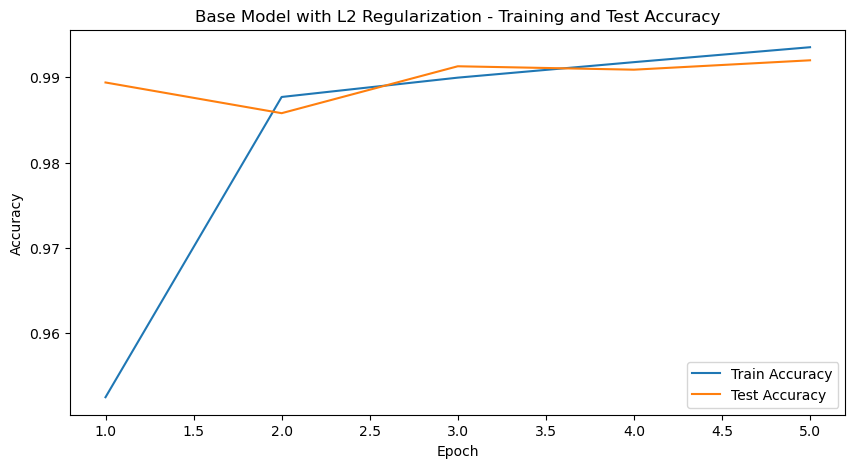

In [18]:
model_l2 = BaseCNN().to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization (weight_decay)
l2_lambda = 1e-4  # Regularization strength
optimizer = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=l2_lambda)

# Training function with L2 regularization
def train_model_l2(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_acc_history = []
    test_acc_history = []
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        test_acc_history.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return train_acc_history, test_acc_history

# Train the model with L2 regularization
epochs = 5
train_acc_l2, test_acc_l2 = train_model_l2(model_l2, train_loader, test_loader, criterion, optimizer, epochs)

# Plot training and test accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_acc_l2, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_l2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Base Model with L2 Regularization - Training and Test Accuracy')
plt.legend()
plt.show()


# Task D

In [19]:
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(CNNWithDropout, self).__init__()
        self.conv_layer = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional Layer 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Convolutional Layer 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  # Dropout after first fully connected layer
            nn.Linear(128, 10)  # Output layer
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

Epoch [1/5], Train Accuracy: 0.9468, Test Accuracy: 0.9868
Epoch [2/5], Train Accuracy: 0.9853, Test Accuracy: 0.9910
Epoch [3/5], Train Accuracy: 0.9894, Test Accuracy: 0.9910
Epoch [4/5], Train Accuracy: 0.9911, Test Accuracy: 0.9898
Epoch [5/5], Train Accuracy: 0.9926, Test Accuracy: 0.9892


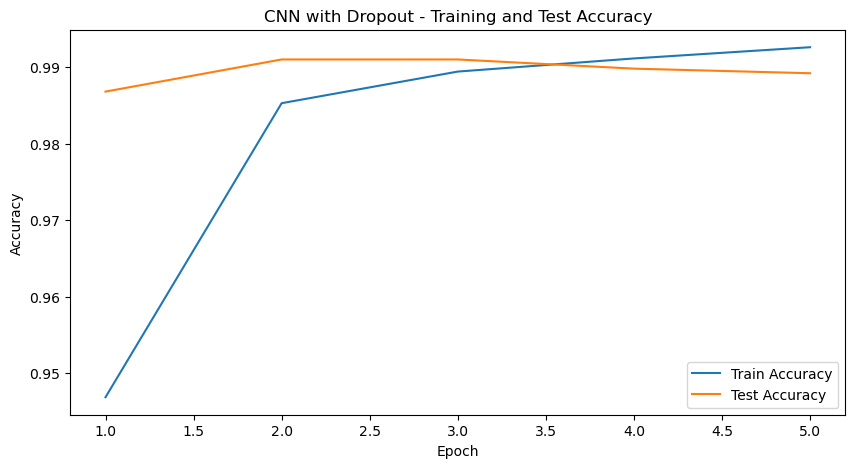

In [20]:
model_dropout = CNNWithDropout().to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)

# Training function with Dropout
def train_model_dropout(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_acc_history = []
    test_acc_history = []
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        test_acc_history.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return train_acc_history, test_acc_history

# Train the model with Dropout
epochs = 5
train_acc_dropout, test_acc_dropout = train_model_dropout(model_dropout, train_loader, test_loader, criterion, optimizer, epochs)

# Plot training and test accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_acc_dropout, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_dropout, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN with Dropout - Training and Test Accuracy')
plt.legend()
plt.show()

# Task e

Epoch [1/5], Train Accuracy: 0.9454, Test Accuracy: 0.9875
Epoch [2/5], Train Accuracy: 0.9852, Test Accuracy: 0.9898
Epoch [3/5], Train Accuracy: 0.9890, Test Accuracy: 0.9805
Epoch [4/5], Train Accuracy: 0.9905, Test Accuracy: 0.9913
Epoch [5/5], Train Accuracy: 0.9918, Test Accuracy: 0.9908


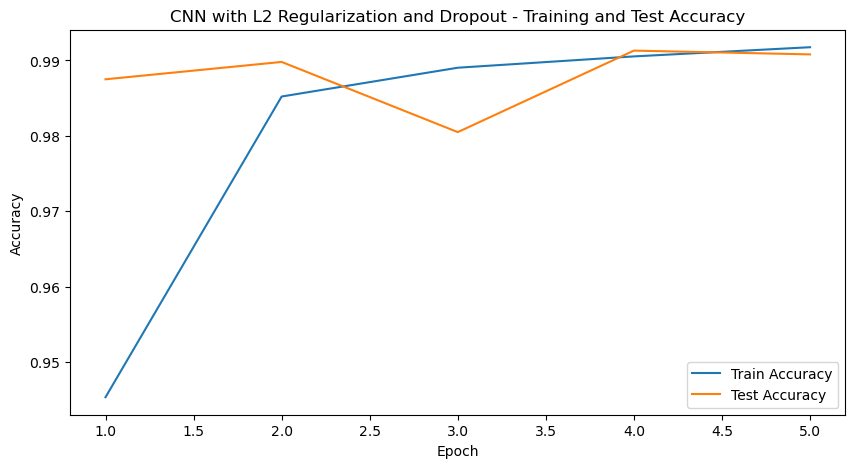

In [21]:
model_l2_dropout = CNNWithDropout().to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization (weight_decay)
l2_lambda = 1e-4  # Regularization strength
optimizer = optim.Adam(model_l2_dropout.parameters(), lr=0.001, weight_decay=l2_lambda)

# Training function with L2 regularization and Dropout
def train_model_l2_dropout(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_acc_history = []
    test_acc_history = []
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        test_acc_history.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return train_acc_history, test_acc_history

# Train the model with both L2 regularization and Dropout
epochs = 5
train_acc_l2_dropout, test_acc_l2_dropout = train_model_l2_dropout(
    model_l2_dropout, train_loader, test_loader, criterion, optimizer, epochs
)

# Plot training and test accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_acc_l2_dropout, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_l2_dropout, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN with L2 Regularization and Dropout - Training and Test Accuracy')
plt.legend()
plt.show()

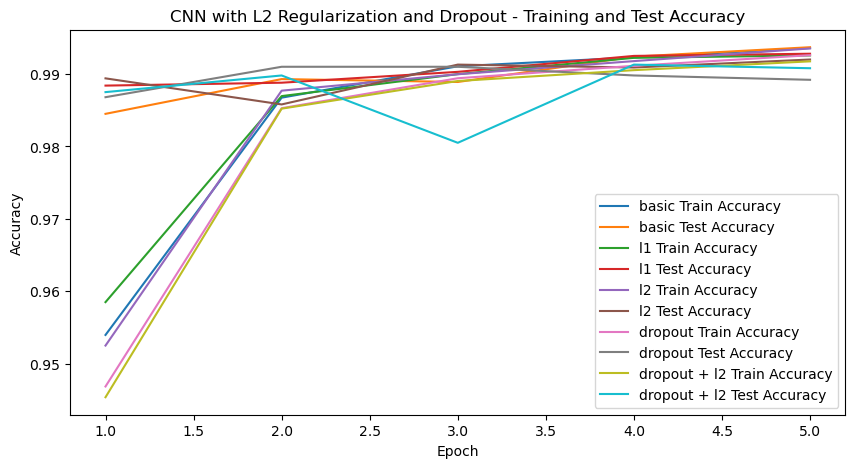

In [22]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), basic_train_acc, label='basic Train Accuracy')
plt.plot(range(1, epochs+1), basic_test_acc, label='basic Test Accuracy')
plt.plot(range(1, epochs+1), train_acc_l1, label='l1 Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_l1, label='l1 Test Accuracy')
plt.plot(range(1, epochs+1), train_acc_l2, label='l2 Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_l2, label='l2 Test Accuracy')
plt.plot(range(1, epochs+1), train_acc_dropout, label='dropout Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_dropout, label='dropout Test Accuracy')
plt.plot(range(1, epochs+1), train_acc_l2_dropout, label='dropout + l2 Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_l2_dropout, label='dropout + l2 Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN with L2 Regularization and Dropout - Training and Test Accuracy')
plt.legend()
plt.show()